In [4]:
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import interp2d
warnings.filterwarnings('ignore')
#import datetime
import scipy.ndimage as ndimage
from matplotlib import cm
import geopy.distance
#import matplotlib as mpl

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import leafmap
import plotly.express as px

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
#import pysplit
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [6]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [11]:
data = pd.read_csv(r'C:\Users\taiwoajayi\OneDrive - University of Arizona\python\trajectory.csv')
# Preprocessing: Remove missing or invalid data
data = data.dropna()
data

,Unnamed: 0,Timestep,Latitude,Longitude,Altitude_AGL_m,Pressure_mb,tpot,tamb,rain,mixd,relh,sphu,mixr,dswf,terr,Launch_UTC,Launch_Altitude_AGL_m
0,0,0.0,32.437,-64.956,1531.6,848.7,300.8,287.0,0.0,646.9,71.6,8.3,8.4,0.0,79.4,2022-06-02 11:23:00,1531.6
1,1,-0.4,32.442,-65.065,1501.1,851.7,300.7,287.2,0.0,643.6,72.6,8.4,8.6,0.0,66.7,2022-06-02 11:23:00,1531.6
2,2,-1.4,32.440,-65.350,1404.4,861.6,300.3,287.8,0.1,702.5,70.7,8.5,8.6,0.0,33.2,2022-06-02 11:23:00,1531.6
3,3,-2.4,32.426,-65.638,1305.4,869.9,299.9,288.2,0.2,739.0,72.8,8.9,9.0,0.0,0.0,2022-06-02 11:23:00,1531.6
4,4,-3.4,32.403,-65.924,1203.6,883.7,299.3,288.9,0.0,748.6,74.6,9.3,9.5,0.0,0.0,2022-06-02 11:23:00,1531.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227682,68,-67.4,55.507,-100.548,1850.9,769.0,296.3,274.9,1.0,1486.8,94.4,5.3,5.3,311.4,459.9,2022-06-18 15:23:00,25.4
227683,69,-68.4,55.378,-100.447,1826.7,768.7,296.0,274.6,0.9,1808.9,93.8,5.1,5.2,311.4,462.0,2022-06-18 15:23:00,25.4
227684,70,-69.4,55.171,-100.353,1789.2,768.2,296.0,274.5,0.0,2381.5,90.4,4.9,5.0,311.4,504.6,2022-06-18 15:23:00,25.4
227685,71,-70.4,54.916,-100.291,1799.9,772.4,296.2,275.1,0.0,1840.1,81.9,4.6,4.7,302.4,471.5,2022-06-18 15:23:00,25.4


In [25]:
# Select the features for clustering
features = data[['Latitude', 'Longitude', 'Altitude_AGL_m']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform clustering using K-means
num_clusters = 4  # Number of desired clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
labels = kmeans.fit_predict(features_scaled)

# Add the cluster labels to the DataFrame
data['cluster_label'] = labels

# Analyzing the results
cluster_counts = data['cluster_label'].value_counts()

# Print the number of trajectories in each cluster
print("Cluster Counts:")
print(cluster_counts)




Cluster Counts:
cluster_label
0    132671
2     40755
3     33367
1     20894
Name: count, dtype: int64


In [27]:
cluster_co = data['cluster_label']
co = pd.DataFrame(cluster_co)
co.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/to.csv')

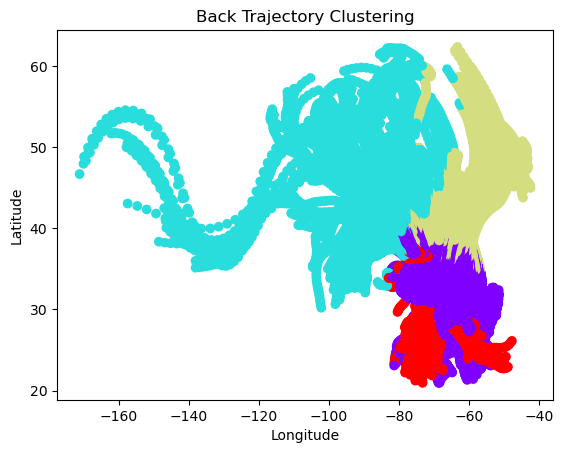

In [28]:
# Visualize the clusters
plt.scatter(data['Longitude'], data['Latitude'], c=data['cluster_label'], cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Back Trajectory Clustering')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the back trajectory data into a DataFrame
# Assume the data is stored in a CSV file with columns 'latitude', 'longitude', 'altitude', etc.
df = pd.read_csv('back_trajectory_data.csv')

# Select the variables to be used for clustering
variables = ['latitude', 'longitude']

# Normalize the variables
df_normalized = (df[variables] - df[variables].mean()) / df[variables].std()

# Perform K-means clustering to identify trajectory groups
n_clusters = 3  # Number of clusters/groups
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_normalized[variables])
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
df['cluster_label'] = cluster_labels

# Plot each group separately
groups = df.groupby('cluster_label')

for group_label, group_data in groups:
    plt.scatter(group_data['longitude'], group_data['latitude'], label=f'Group {group_label}')
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Back Trajectory Clustering')
plt.legend()
plt.show()


In [29]:
# Select the features for clustering
features = data[['Latitude', 'Longitude', 'Altitude_AGL_m']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform clustering using K-means
num_clusters = 4  # Number of desired clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
labels = kmeans.fit_predict(features_scaled)

# Add the cluster labels to the DataFrame
data['cluster_label'] = labels

# Group variables by cluster
groups = data.groupby('cluster_label')

# Analyzing the results
#cluster_counts = data['cluster_label'].value_counts()

# Print the number of trajectories in each cluster
#print("Cluster Counts:")
#print(cluster_counts)

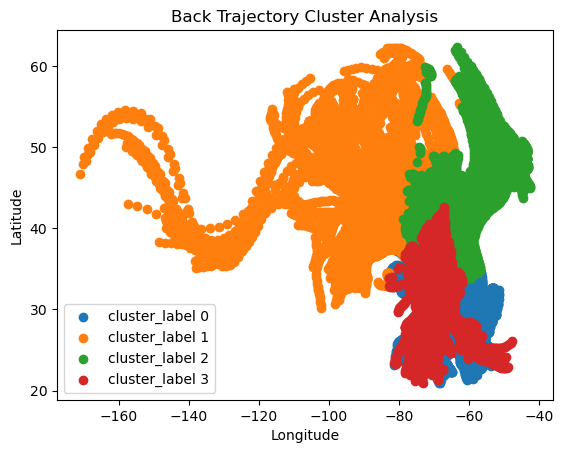

In [34]:
# Plot each group separately
fig, ax = plt.subplots()
for cluster_label, group in groups:
    ax.scatter(group['Longitude'], group['Latitude'], label=f'cluster_label {cluster_label}')

# Set plot title and labels
ax.set_title('Back Trajectory Cluster Analysis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(0)
n_samples = 100
n_features = 2
data = np.random.randn(n_samples, n_features)

# Perform clustering using K-means
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(data)

# Create a DataFrame with data and cluster labels
df = pd.DataFrame(data, columns=['Variable1', 'Variable2'])
df['Cluster'] = clusters

# Group variables by cluster
groups = df.groupby('Cluster')

# Plot each group separately
fig, ax = plt.subplots()
for cluster, group in groups:
    ax.scatter(group['Variable1'], group['Variable2'], label=f'Cluster {cluster}')

# Set plot title and labels
ax.set_title('Back Trajectory Cluster Analysis')
ax.set_xlabel('Variable1')
ax.set_ylabel('Variable2')
ax.legend()

# Show the plot
plt.show()
